In [9]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import os
import io
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import ResNet152 # Load pre-trained model

In [10]:
# Add labels for classification
labels = ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

In [11]:
import pickle

In [40]:
X_train = []
Y_train = []

In [41]:
X_test = []
Y_test = []

In [13]:
# Reading from pickle file
f = open('train.pickle', 'rb')
train_data = pickle.load(f)
f.close()

In [16]:
# Reading from pickle file
f = open('test.pickle', 'rb')
test_data = pickle.load(f)
f.close()

In [42]:
for i, j in train_data:
    X_train.append(i)
    Y_train.append(j)

In [43]:
for i, j in test_data:
    X_test.append(i)
    Y_test.append(j)

In [44]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [45]:
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

In [46]:
Y_train.shape

(1266345, 14)

In [47]:
# Create the model

# 
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(8, activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(14, activation = 'softmax'))

# Optimization
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

# Compile model
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

# Model Summary
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 62, 62, 8)         224       
                                                                 
 conv2d_25 (Conv2D)          (None, 60, 60, 8)         584       
                                                                 
 conv2d_26 (Conv2D)          (None, 58, 58, 8)         584       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 29, 29, 8)        0         
 2D)                                                             
                                                                 
 dense_12 (Dense)            (None, 29, 29, 8)         72        
                                                                 
 conv2d_27 (Conv2D)          (None, 27, 27, 64)        4672      
                                                      

In [48]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("kavach.h5", monitor = "val_accuracy", save_best_only = True, 
                             mode = "auto", verbose = 1)
reducelearningrate = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.05, min_delta = 0.001,
                              mode = 'auto', verbose = 1)

In [ ]:
# Train the model
training = model.fit(X_train, Y_train, validation_split = 0.3, batch_size = 100, epochs = 5, verbose = 1,
                   callbacks = [tensorboard, checkpoint, reducelearningrate])

Epoch 1/5
8865/8865 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9877
Epoch 1: val_accuracy improved from -inf to 0.57412, saving model to kavach.h5
8865/8865 [==============================] - 19303s 2s/step - loss: 0.0437 - accuracy: 0.9877 - val_loss: 12.0559 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 2/5
8865/8865 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9951
Epoch 2: val_accuracy improved from 0.57412 to 0.57412, saving model to kavach.h5
8865/8865 [==============================] - 12292s 1s/step - loss: 0.0176 - accuracy: 0.9951 - val_loss: 11.2700 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 3/5
 306/8865 [>.............................] - ETA: 1:34:42 - loss: 0.0096 - accuracy: 0.9974

In [ ]:
from keras.utils.vis_utils import plot_model
!pip install visualkeras
import visualkeras
plot_model(model, to_file='kavach.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model)

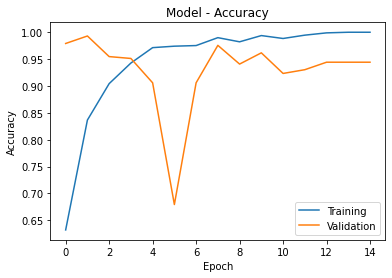

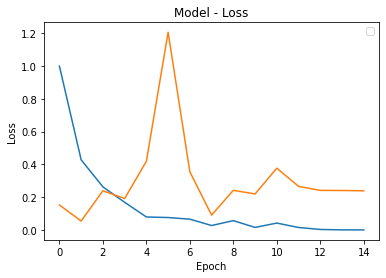

In [35]:
# Plot Accuracy
fig1, ax_acc = plt.subplots()
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot Loss
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model - Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.show()

In [36]:
# Prediction
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis = 1)
Y_test_new = np.argmax(Y_test, axis = 1)

13/13 [==============================] - 1s 38ms/step


In [37]:
# Model Features
print(classification_report(Y_test_new, prediction))
print(confusion_matrix(Y_test_new, prediction))

              precision    recall  f1-score   support

           0       0.90      0.18      0.30       100
           1       0.67      0.97      0.79       115
           2       0.67      1.00      0.80       105
           3       0.94      0.66      0.78        74

    accuracy                           0.72       394
   macro avg       0.80      0.70      0.67       394
weighted avg       0.78      0.72      0.67       394

[[ 18  35  45   2]
 [  0 111   3   1]
 [  0   0 105   0]
 [  2  19   4  49]]


In [40]:
# Loading the saved model with 99.303% validation accuracy
loadedmodel = load_model('/content/drive/MyDrive/ColabNotebooks/Telemedicine/tumorpredictioncustom99.303,100.h5')
pred = loadedmodel.predict(X_test)
pred = np.argmax(pred, axis = 1)
Y_test_new = np.argmax(Y_test, axis = 1)
print(classification_report(Y_test_new, pred))
print(confusion_matrix(Y_test_new, pred))

13/13 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.67      0.18      0.28       100
           1       0.65      0.21      0.32       115
           2       0.46      0.87      0.60       105
           3       0.48      0.84      0.61        74

    accuracy                           0.49       394
   macro avg       0.56      0.52      0.45       394
weighted avg       0.57      0.49      0.44       394

[[18  7 57 18]
 [ 5 24 47 39]
 [ 2  1 91 11]
 [ 2  5  5 62]]


In [41]:
loss, accuracy = loadedmodel.evaluate(X_test, Y_test, verbose = 1)

13/13 [==============================] - 1s 27ms/step - loss: 2.0850 - accuracy: 0.4949


In [47]:
# Final Prediction of user input image

# Input Image
img = cv2.imread('/content/drive/MyDrive/ColabNotebooks/Telemedicine/ntest7.jpg')

# Image Preprocessing
img = cv2.resize(img, (200, 200))
img = img.reshape(1, 200, 200, 3)

# Model Prediction
p = loadedmodel.predict(img)
p = np.argmax(p, axis = 1)[0]

# Display Output
if p == 0:
  p = 'Glioma Tumor'
elif p == 1:
  p = 'Meningioma Tumor'
elif p == 2:
  p = 'No Tumor'
elif p == 3:
  p = 'Pituitary Tumor'
if p != 1:
  print(f'The image uploaded is a {p} Scan')

1/1 [==============================] - 0s 33ms/step
The image uploaded is a No Tumor Scan
